In [1]:
import torch
import math
import os
from datetime import datetime
import flwr

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

torch.manual_seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch._dynamo.config.suppress_errors = True

In [2]:
class AttentionHead(nn.Module):

    def __init__(self, emb_dim, head_size, context_window_len, mask):
        super(AttentionHead, self).__init__()
        # These Layers Map (B, W, E) -> (B, W, HEAD_SIZE)

        assert mask == 'encoder' or mask == 'decoder'

        self.key = nn.Linear(emb_dim, head_size, bias=False, device=device)
        self.query = nn.Linear(emb_dim, head_size, bias=False, device=device)
        self.value = nn.Linear(emb_dim, head_size, bias=False, device=device)
        self.mask_type = mask
        self.context_window_len = context_window_len
        self.head_size = head_size

    # Returns a mask of (W, W)
    def get_mask_tensor(self):
        if (self.mask_type == 'encoder'):
            return torch.tril(torch.ones(self.context_window_len, self.context_window_len, device=device))
        elif (self.mask_type == 'decoder'):
            return torch.ones(self.context_window_len, self.context_window_len, device=device)
    
    # Input is of shape (B, W, E) where E is embedding dimensions.
    # Output is of shape (B, W, E)
    def forward(self, input):
        k = self.key(input) # Convert (B, W1, E) -> (B, W1, HEAD_SIZE)
        q = self.query(input) # Convert (B, W2, E) -> (B, W2, HEAD_SIZE) (W1 == W2 == W3)
        v = self.value(input) # (B, W3, E) -> (B, W3, HEAD_SIZE)
        match = q @ k.transpose(-2, -1) # Produce Matrix (B, W1, W2)
        mask = self.get_mask_tensor()
        match = match.masked_fill(mask == 0, float('-inf'))
        attention = torch.softmax(match, dim=-1) / math.sqrt(self.head_size) # Still (B, W1, W2)

        res = attention @ v # (B, W1, W2) @ (B, W3, HEAD_SIZE) -> (B, W1=W3, HEAD_SIZE)
        return res

In [3]:
class MultiHeadedAttention(nn.Module):

    def __init__(self, emb_dim, num_heads, context_window_len, mask):
        super(MultiHeadedAttention, self).__init__()
        assert emb_dim % num_heads == 0
        self.attention_heads = [AttentionHead(emb_dim, emb_dim // num_heads, context_window_len, mask) for i in range(0, num_heads)]
        

    # Input is (B, W, E)
    def forward(self, input):
        # Each ah returns (B, W, E/num_heads)
        return torch.cat([ah(input) for ah in self.attention_heads], dim= -1)


In [4]:
class Block(nn.Module):
    def __init__(self, context_window_size, embedding_dimensions, num_heads, hidden_layer_multiplier = 4, dropout_rate = 0.3):
        super(Block, self).__init__()

        self.network = nn.Sequential(
            MultiHeadedAttention(embedding_dimensions, num_heads, context_window_size, 'encoder'),
            nn.Linear(embedding_dimensions, hidden_layer_multiplier * embedding_dimensions, device=device),
            nn.ReLU(),
            nn.Linear(embedding_dimensions * hidden_layer_multiplier, embedding_dimensions, device=device),
            nn.LayerNorm(embedding_dimensions, device=device),
            nn.Dropout(dropout_rate)
        )

    # Raw input is a tesnor of (B, W). It should have already mapped tokens to integer.
    def forward(self, raw_input):
        return self.network(raw_input)

class CustomTransformer(nn.Module):

    # Input to the Transformer will be a matrix of size (B, W)
    # B is the Batch Size.
    # W is the Window Size (context_window_size)
    # Example:
    # [a, b, c]
    # [d, e, f]
    #
    # [a, b, c] is an input example. (context_len = W = 3)
    # There are two batches [a, b, c] and [d, e, f] (B = 2)
    # a, b, c should be integers (each representing one possible token). a, b, c should belong in [0, dict_size)
    def __init__(self, dict_size, context_window_size, embedding_dimensions, num_heads, block_count):
        super(CustomTransformer, self).__init__()
        self.context_window_size = context_window_size
        self.token_embedding = nn.Embedding(dict_size, embedding_dimensions, device=device)
        self.position_embedding = nn.Embedding(context_window_size, embedding_dimensions, device=device)
        self.decoder = nn.Linear(embedding_dimensions, dict_size, device=device)

        self.network = nn.Sequential(
            *[Block(context_window_size, embedding_dimensions, num_heads) for _ in range(0, block_count)]
        )

    def embed(self, input, spatial = False):
        emb = self.token_embedding(input)
        if (spatial):
            return emb + self.position_embedding(torch.arange(0, self.context_window_size, device=device))

        return emb

    # Raw input is a tesnor of (B, W). On CPU. It should have already mapped tokens to integer.
    def forward(self, raw_input, targets):
        if(raw_input.device != device):
            raw_input = raw_input.to(device)
        input = self.embed(raw_input, True)
        logits = self.network(input)
        logits = self.decoder(logits)
        if (targets != None):
            if(targets.device != device):
                targets = targets.to(device)
            logits_1d = logits.view(logits.shape[0] * logits.shape[1], logits.shape[2])
            targets = targets.view(logits_1d.shape[0])
            loss = F.cross_entropy(logits_1d, targets)
        else:
            loss = None
        return logits, loss

In [5]:
DELIMITER = "<|endoftext|>"
PADDING = "<|padding|>"
VOCAB_SIZE = 2500

DELIM_ENCODED = 0
PADDING_ENCODED = 1

In [6]:
def split(x : list, delim):
    ind = x.index(delim) if delim in x else -1
    if (ind == -1):
        return [x]
    y = split(x[ind + 1:], delim)
    cur = x[:ind]
    return [x[:ind]] + y if len(cur) != 0 else y

#print(split([1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4], 1))

def get_padded_longest_sample(encoded : list[int]):
    splits = split(encoded, DELIM_ENCODED)
    splits.sort(key=lambda x: -len(x))
    item = splits[0]
    if (len(splits) > 1):
        splits[0].append(DELIM_ENCODED)
#    print((CONTEXT_LEN - len(splits[0])))
    res = [PADDING_ENCODED] * (CONTEXT_LEN - len(splits[0]))
    res = res + splits[0]
#    print(res)
#    print("Final: ", tokenizer.decode(res))
    return res;

def remove_padding(encoded : list[int]):
    return [x for i, x in enumerate(encoded) if x not in [DELIM_ENCODED, PADDING_ENCODED]]

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, context_len):
        self.data = data.ids
        print(self.data[0:100])
        self.context_len = context_len

    # ABCDE for context len of 1 has 4 examples: (A, B), (B, C), (C, D), (D, E)
    # for context len 2 has examples 3 (AB, C), (BC, D), (CD, E)
    def __len__(self):
        return len(self.data) - self.context_len

    def __getitem__(self, idx):
        return torch.tensor(get_padded_longest_sample(self.data[idx : idx + self.context_len]), device = device), torch.tensor(get_padded_longest_sample(self.data[idx + 1 :idx + self.context_len + 1]), device=device)

In [7]:
import codecs
def convert_to_utf8(input_file, output_file):
    with open(input_file, 'rb') as file:
        content = file.read()
        
    decoded_content = content.decode('utf-8', errors='replace')
        
    with codecs.open(output_file, 'w', encoding='utf-8') as file:
        file.write(decoded_content)
        


# import coDesc_parser
# #4211516
# #res = coDesc_parser.fragment_dataset("../data/CoDesc/CoDesc.json", "../data/CoDesc/fragmented")
# #print(res)

# random_samples = torch.randint(0, 4211516, (100000,)).tolist()
# train_indices = random_samples[:80000]
# test_indices = random_samples[80000:]
# coDesc_parser.fragmented_files_to_txt_file(train_indices, "../data/CoDesc/fragmented", DELIMITER, "train.txt")
# coDesc_parser.fragmented_files_to_txt_file(test_indices, "../data/CoDesc/fragmented", DELIMITER, "test.txt")

# #coDesc_parser.fragmented_files_to_txt_file(range(90), "../data/CoDesc/fragmented", DELIMITER, "train.txt")
# #coDesc_parser.fragmented_files_to_txt_file(range(90, 100), "../data/CoDesc/fragmented", DELIMITER, "test.txt")

#convert_to_utf8("../data/CoDesc/fragmented/train.txt", "../data/CoDesc/fragmented/train_utf8.txt")
#convert_to_utf8("../data/CoDesc/fragmented/test.txt", "../data/CoDesc/fragmented/test_utf8.txt")
    
# from tiktoken._educational import *

In [8]:
# from tiktoken._educational import *

# tokenizer = tiktoken.get_encoding("cl100k_base")

# in_dir = "../data/CoDesc/fragmented"

# with open(os.path.join(in_dir, "train.txt"), "r") as f:
#     train = f.read()

# with open(os.path.join(in_dir, "test.txt"), "r") as f:
#     test = f.read()



# train_simple_encoding = tokenizer.encode(train, allowed_special={"<|endoftext|>"})

# train_enc = tokenizer.encode(train, allowed_special={"<|endoftext|>"})
# test_enc = tokenizer.encode(test, allowed_special={"<|endoftext|>"})

In [9]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=["../data/CoDesc/fragmented/train_utf8.txt"], vocab_size=VOCAB_SIZE, min_frequency=2, special_tokens=[DELIMITER, PADDING])

if not os.path.exists("../data/tokenizer"):
    os.makedirs("../data/tokenizer")

tokenizer.save_model("../data/tokenizer")

#tokenizer = ByteLevelBPETokenizer("../data/tokenizer/vocab.json", "../data/tokenizer/merges.txt")


['../data/tokenizer\\vocab.json', '../data/tokenizer\\merges.txt']

In [10]:

train = open("../data/CoDesc/fragmented/train_utf8.txt", "r").read()
test = open("../data/CoDesc/fragmented/test_utf8.txt", "r").read()

train_enc = tokenizer.encode(train)
test_enc = tokenizer.encode(test)

In [11]:
CONTEXT_LEN = 256
BLOCK_COUNT = 2
EMBED_DIM = 1024
NUM_HEADS = 32
LEARNING_RATE = 1e-2
BATCH_COUNT = 32
ITERATIONS = 50000

In [12]:
transformer = CustomTransformer(VOCAB_SIZE, CONTEXT_LEN, EMBED_DIM, NUM_HEADS, BLOCK_COUNT)
optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

print(sum(p.numel() for p in transformer.parameters()))

22176196


In [13]:
def complete(ctx, new_len):
    res = [x for x in ctx]
    
    for _ in range(new_len):
        ctx = torch.tensor([res[-CONTEXT_LEN:]])
        prob, loss = transformer(ctx, None) # Returns a tensor of size (1, W, EM)
        prob = prob.squeeze(0)
        prob = torch.softmax(prob, dim=-1) # (1, W, EM)
        pred = torch.multinomial(prob, 1) # (1, W, 1)
        res.append(pred[-1, 0].item())
    return tokenizer.decode(res[-new_len:])

In [14]:
train_dataset = TextDataset(train_enc, CONTEXT_LEN)
train_loader = DataLoader(train_dataset, BATCH_COUNT, shuffle=True)

transformer = torch.compile(transformer)
#transformer.load_state_dict(torch.load("../data/out/model.pt"))

[0, 739, 2061, 601, 265, 270, 271, 2085, 478, 580, 1105, 295, 624, 85, 1623, 601, 905, 560, 264, 289, 692, 1459, 1904, 475, 485, 278, 281, 358, 546, 295, 465, 265, 403, 299, 278, 399, 295, 299, 390, 560, 264, 289, 692, 1459, 1904, 284, 732, 295, 299, 1105, 270, 271, 560, 264, 289, 692, 1459, 1904, 475, 299, 485, 278, 364, 295, 280, 1665, 278, 399, 295, 280, 0, 200, 336, 508, 575, 475, 485, 2296, 2240, 2065, 46, 434, 265, 575, 356, 290, 324, 575, 1138, 72, 324, 403, 285, 72, 324, 403, 222, 696, 462, 267]


In [15]:
loss_history = []
history = []
loss_avg_block_size = 10

#train_dataset = TextDataset(train_enc, CONTEXT_LEN)
# Prefetch the first batch
#train_in, train_target = get_batches(train_enc, BATCH_COUNT, CONTEXT_LEN)

#load model
#transformer = CustomTransformer(tokenizer.n_vocab, CONTEXT_LEN, EMBED_DIM, NUM_HEADS, BLOCK_COUNT)

out_dir = "../data/out22M/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

i = 0
for current_train_in, current_train_target in train_loader:
    start_time = datetime.now()
    # Process the current batch
    print(current_train_in.shape)
    logits, loss = transformer(current_train_in, current_train_target)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    history.append(loss.item())
    print (f"Iteration {i} Loss: {history[-1]}")
    if (len(history) >= loss_avg_block_size):
        loss_history.append(torch.tensor(history).mean().item())
        history = []
        print (f"Iteration {i} Loss: {loss_history[-1]}")
    i += 1

    if (not os.path.exists(out_dir)):
        os.makedirs(out_dir)

    torch.save(transformer.state_dict(), os.path.join(out_dir, "model.pt"))
    end_time = datetime.now()

    total_seconds = (end_time - start_time).total_seconds()

    with open(os.path.join(out_dir, "loss.txt"), "a+") as f:
        f.write(f"Loss: {str(loss)}___________Time: {total_seconds}s\n")

    if (i >= ITERATIONS):
        break

if (len(history) > 0):
    loss_history.append(torch.tensor(history).mean().item())

torch.Size([32, 256])


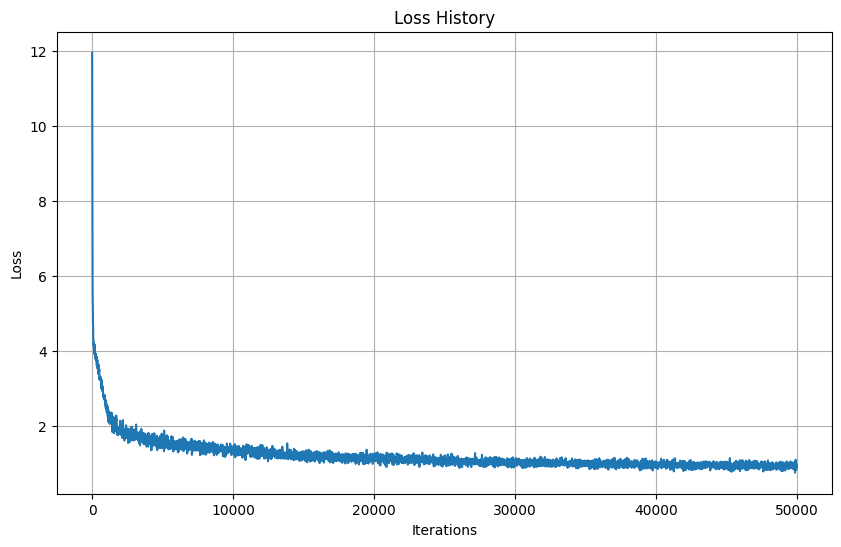

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history * loss_avg_block_size) + 1, loss_avg_block_size), loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.grid(True)
plt.show()


In [ ]:
start = torch.randint(0, len(test_enc) - CONTEXT_LEN, (1,)).item()
sampled_txt = test_enc.ids[start:start + CONTEXT_LEN]
print("_________________________SAMPLED_________________________:")
print(tokenizer.decode(sampled_txt))
print("_________________________PREDICTED_______________________:")
x = complete(sampled_txt, CONTEXT_LEN)
print("".join(remove_padding(x)))

_________________________SAMPLED_________________________:
PluggableType pluggableType=BackendDescriptor.PluggableType.UNKNOWN;
      if (cn != null && cn.endsWith(DATABASE_JE_MONITORING_ENTRY_SUFFIX)) {
        pluggableType=BackendDescriptor.PluggableType.JE;
        monitorBackendID=cn.substring(0,cn.length() - DATABASE_JE_MONITORING_ENTRY_SUFFIX.length());
      }
      if (cn != null && cn.endsWith(DATABASE_PDB_MONITORING_ENTRY_SUFFIX)) {
        pluggableType=BackendDescriptor.PluggableType.PDB;
        monitorBackendID=cn.substring(0,cn.length() - DATABASE_PDB_MONITORING_ENTRY_SUFFIX
_________________________PREDICTED_______________________:
,0,ASE_CONFRELTERERENCEMCAPPROVID,fs.variableCompospVED_RESS);
        getSrc.start();
      }
       MessageType.set(asser_TYPE,ge);
    }
    return level;
    AIREWORY;
    else {
    }
    if (level != null) {
      cn=(cmpS + 1) >>> 1) {
           for (Cubst.nf : zplu > Colorphice	float b.nDB.Counts) {
        return NEqualledlyphaNeed

In [ ]:
# bob = sy.VirtualWorker(id="bob") 
# alice = sy.VirtualWorker(id="alice")
# x = torch.tensor([25]).share(bob,alice) 
# y = torch.tensor([5]).share(bob,alice)
# print("Bob share of x (==25): ", list(bob._tensors.values())[0]) # inspect the encrypted values 
# print("Alice share of x (==25): ", list(alice._tensors.values())[0]) # inspect the encrypted values 
# print("Adding both shares of x (==25): ", list(bob._tensors.values())[0]+list(alice._tensors.values())[0]) # manually decrypt the first tensor (25) by adding the 2 users shares
# # manually add 2 encrypted numbers 
# share_bob = list(bob._tensors.values())[0] + list(bob._tensors.values())[1] 
# share_alice = list(alice._tensors.values())[0] + list(alice._tensors.values())[1]
# print("Bob share of x+y (==30): ",share_bob)
# print("ALice share of x+y (==30): ",share_alice)
# print("Manual reconstruction of x + y: ", share_bob+share_alice)
# # add two encryted numbers using Pysyft 
# z = x + y 
# print("Automatic reconstruction of x + y: ", z.get())

NameError: name 'syft' is not defined